In [1]:
import numpy as np
import pandas as pd

from itertools import chain
from matplotlib import pyplot as plt

from parse_input_file import parse_file
from create_feature_dfs import compose_signals_df, create_initial_input
from LeastSquaresMethod import LeastSquaresMethod
from RecursiveLeastSquaresMethod import RecursiveLeastSquaresMethod
from metrics import count_model_coef_rmse, rsse, determination_coef, rmse, akkake_criteria

In [2]:
#parsing_result = parse_file('Test+')
#features_dfs = compose_signals_df(parsing_result)

In [3]:
a_coefs = [0,0.15,-0.33,0.25]
b_coefs = [1,0.3,0.7,0.]

parsing_result = create_initial_input(a_coefs, b_coefs, uniform_low=0, uniform_high=100, time_series_shape=1000, noise_std=2)
features_dfs = compose_signals_df(parsing_result)

In [4]:
features_dfs.head()

,y(k),y(k-1),y(k-2),y(k-3),v(k),v(k-1),v(k-2),v(k-3)
0,26.207524,26.507535,10.853798,46.445259,17.841848,23.754918,13.136992,46.266814
1,20.362944,26.207524,26.507535,10.853798,70.667438,17.841848,23.754918,13.136992
2,36.119105,20.362944,26.207524,26.507535,32.881626,70.667438,17.841848,23.754918
3,65.711942,36.119105,20.362944,26.207524,79.418672,32.881626,70.667438,17.841848
4,49.783062,65.711942,36.119105,20.362944,45.220178,79.418672,32.881626,70.667438


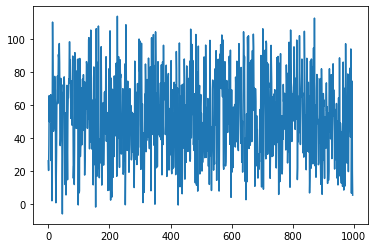

In [5]:
features_dfs['''y(k)'''].plot()

In [6]:
coefs_to_ignore = []#['''y(k-{})'''.format(i) for i in [4,5]] + ['''v(k-{})'''.format(i) for i in [4,5]]

# Least Square Method

In [7]:
ls_method = LeastSquaresMethod(biased=True)

In [8]:
ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
              y=np.array(features_dfs['''y(k)''']))

In [9]:
ls_pred = ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)))

In [10]:
print({
    'rsse': rsse(np.array(features_dfs['''y(k)''']), ls_pred)/ls_pred.shape[0],
    'determination_coef': determination_coef(np.array(features_dfs['''y(k)''']), ls_pred),
    'akke_coef':akkake_criteria(np.array(features_dfs['''y(k)''']), ls_pred, ls_method.coef_matrix.shape[0])
})

{'rsse': 4.000127988787725, 'determination_coef': 0.9935798719063379, 'akke_coef': 8282.20389638346}


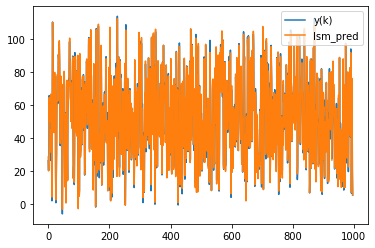

In [11]:
features_dfs['lsm_pred'] = ls_pred
features_dfs[['''y(k)''','lsm_pred']].plot();
features_dfs.drop(columns='lsm_pred', inplace=True)

In [12]:
all_results = []
for y_idx in range(3,0,-1):
    for v_idx in range(3,0, -1):
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        print(coefs_to_ignore)
        ls_method = LeastSquaresMethod(biased=True)
        ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                      y=np.array(features_dfs['''y(k)''']))
        ls_pred = ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)))
        res_dict ={
                    
                    'rsse': rsse(np.array(features_dfs['''y(k)''']), ls_pred),
                    'determination_coef': determination_coef(np.array(features_dfs['''y(k)''']), ls_pred),
                    'akke_coef':akkake_criteria(np.array(features_dfs['''y(k)''']), ls_pred, ls_method.coef_matrix.shape[0])
                    }
        all_results.append(res_dict)

['y(k-1)', 'y(k-2)', 'v(k-1)', 'v(k-2)']
['y(k-1)', 'y(k-2)', 'v(k-1)']
['y(k-1)', 'y(k-2)']
['y(k-1)', 'v(k-1)', 'v(k-2)']
['y(k-1)', 'v(k-1)']
['y(k-1)']
['v(k-1)', 'v(k-2)']
['v(k-1)']
[]


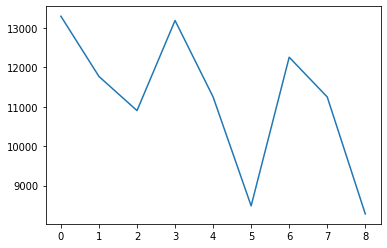

In [13]:
plt.plot([all_results[i]['akke_coef']for i in range(len(all_results))])

# Analyse Least Square Method coefs

In [14]:
#count_model_coef_rmse(ls_method, parsing_result)

nedded_coefs = np.array(list(chain(*[[parsing_result['out_weights'][i]] for i in [0,1,2,3]])) + \
                        list(chain(*[[parsing_result['manage_weights'][i]] for i in [0,1,2,3]])))
rmse(nedded_coefs, ls_method.coef_matrix.squeeze())

1.6791981232259103

# Recursive Least Square Method

In [15]:
num_features = features_dfs.shape[1] - len(coefs_to_ignore) - 1

In [16]:
rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=num_features, biased=True)

In [17]:
rls_pred, rls_coefs = rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                                             y=np.array(features_dfs['''y(k)''']))

In [18]:
all_results = []
for y_idx in reversed(range(1,4)):
    for v_idx in reversed(range(1,4)):
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        print(coefs_to_ignore)
        num_features = features_dfs.shape[1] - len(coefs_to_ignore) - 1
        rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=num_features, biased=True)
        rls_pred, rls_coefs = rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                                             y=np.array(features_dfs['''y(k)''']))
        res_dict ={
                    'rsse': rsse(np.array(features_dfs['''y(k)''']), rls_pred),
                    'determination_coef': determination_coef(np.array(features_dfs['''y(k)''']), rls_pred),
                    'akke_coef':akkake_criteria(np.array(features_dfs['''y(k)''']), rls_pred, rls_method.coef_matrix.shape[0])
                    }
        all_results.append(res_dict)

['y(k-1)', 'y(k-2)', 'v(k-1)', 'v(k-2)']
['y(k-1)', 'y(k-2)', 'v(k-1)']
['y(k-1)', 'y(k-2)']
['y(k-1)', 'v(k-1)', 'v(k-2)']
['y(k-1)', 'v(k-1)']
['y(k-1)']
['v(k-1)', 'v(k-2)']
['v(k-1)']
[]


In [19]:
np.argmin([all_results[i]['rsse']for i in range(len(all_results))])

8

In [20]:
all_results

[{'rsse': 781998.1113551245,
  'determination_coef': 0.3702790407251686,
  'akke_coef': 13536.8987815645},
 {'rsse': 135001.50266267004,
  'determination_coef': 0.8871355108102059,
  'akke_coef': 11787.602064628632},
 {'rsse': 55163.0118282631,
  'determination_coef': 0.8502948957634164,
  'akke_coef': 10897.293788292998},
 {'rsse': 757146.2596212814,
  'determination_coef': 0.4390860682375577,
  'akke_coef': 13506.699788126478},
 {'rsse': 91540.09289634874,
  'determination_coef': 1.0359961907610158,
  'akke_coef': 11402.258732037053},
 {'rsse': 5054.442783063213,
  'determination_coef': 1.004063968136919,
  'akke_coef': 8516.438825847084},
 {'rsse': 210698.65854095836,
  'determination_coef': 0.7370045882027111,
  'akke_coef': 12233.409680394792},
 {'rsse': 86262.8945433046,
  'determination_coef': 1.0042846495939355,
  'akke_coef': 11345.05936119365},
 {'rsse': 3859.1561453141517,
  'determination_coef': 0.9891261939018355,
  'akke_coef': 8249.429211885436}]

In [23]:
res_dict ={
    'rsse': rsse(np.array(features_dfs['''y(k)''']), rls_pred)/rls_pred.shape[0],
    'determination_coef': determination_coef(np.array(features_dfs['''y(k)''']), rls_pred),
    'akke_coef':akkake_criteria(np.array(features_dfs['''y(k)''']), rls_pred, rls_method.coef_matrix.shape[0])
}
res_dict

{'rsse': 3.87076845066615,
 'determination_coef': 0.9891261939018355,
 'akke_coef': 8249.429211885436}

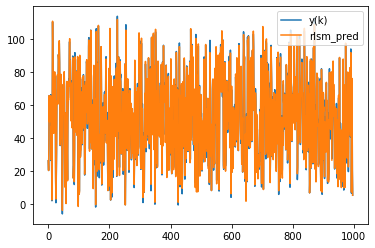

In [25]:
features_dfs['rlsm_pred'] = rls_pred
features_dfs[['''y(k)''','rlsm_pred']].plot();
features_dfs.drop(columns='rlsm_pred', inplace=True)

# Analyse Recursive Least Square Method coefs

In [ ]:
#count_model_coef_rmse(rls_method, parsing_result)

nedded_coefs = np.array(list(chain(*[[parsing_result['out_weights'][i]] for i in [0,1,2,3]])) + \
                        list(chain(*[[parsing_result['manage_weights'][i]] for i in [0,1,2,3]])))
rmse(nedded_coefs, rls_method.coef_matrix.squeeze())

In [ ]:
coefs_rmse = []
for c in rls_coefs:
    coefs_rmse.append(rmse(c, nedded_coefs))
    
plt.plot(coefs_rmse)